# Table of contents

* [Overview](#overview)

# Overview<a id="overview"></a>

Fine tune a GPT 3.5 model for improved performance on named entity recognition tasks on pubmed abstracts.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import json
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
import sys

**Import the openai module.**

In [5]:
import openai_api

**Import the module containing utils functions eg. writing data from df to Google Sheets.**

In [6]:
import utils

**Import the finetuning module.**

In [7]:
import openai_finetuning

# Paths

In [3]:
cwd = Path.cwd()

In [4]:
module_dir = cwd.parent / 'scripts'
sys.path.append(str(module_dir))

### Path to CSV containing literature from 87 papers from PubMed

In [10]:
pubmed_path = cwd.parent/'outputs'/ 'pubmed_data_run_1.csv'

### Prompt language - system and user instructions for generating starting training data

In [11]:
system_path = cwd.parent / 'inputs'/'system_prompt_v1.json'
user_path = cwd.parent /'inputs'/'user_prompt_v1.json'

### Completions for 87 pubmed abstracts processed for entity extraction via GPT-4

In [23]:
completions_path = cwd.parent/'outputs'/'gpt4_completions_run_2.json'

### Results from completions extracted into a CSV

In [28]:
ner_path = cwd.parent/'outputs'/ 'pubmed_ner_gpt4_run_2.csv'

### Prompt language for finetuning

**Option 1 - a shortened prompt.**

In [169]:
ft_user_path = cwd.parent /'inputs'/'user_prompt_v2.json'

**Option 2 - a longer prompt but this is the subset taken from the same prompt used for generating training data by GPT-4.**

In [12]:
ft_user_path_2 = cwd.parent /'inputs'/'user_prompt_v3.json'

### Training data jsonl file

In [210]:
training_path = cwd.parent / 'inputs'/'training_finetuning_v1.jsonl'

### Test data jsonl file

In [229]:
test_path = cwd.parent / 'inputs'/'test_finetuning_v1.jsonl'

### Finetuning results (loss metrics) saved into a CSV along with hyperparameter info

In [8]:
ft_results_path = cwd.parent/'outputs'/'pubmed_ft1_model_loss_metrics.csv'

### Completions for pubmed abstracts from the test set, inference by a finetuned GPT-3.5

In [60]:
ft_completions_path = cwd.parent/'outputs'/'gpt3_5_completions_run_3.json'

### Results from completions from the finetuned model extracted into a CSV

In [82]:
ft_ner_path = cwd.parent/'outputs'/ 'pubmed_ner_gpt3_5_run_3.csv'

# Step 1 - PubMed abstracts extracted using the NCBI PubMed API

This data is ready and was performed in the ner_pubmed_llm notebook. This is how the extracted data looks:

1. Total 87 papers pertaining to 3 cancer types glioblastoma, lung cancer, and breast cancer.
2. Full papers have not been extracted - only the metadata such as title, abstract, keywords, etc.

In [6]:
pubmed_df = pd.read_csv(pubmed_path,dtype={'pmid':'str'})

In [8]:
pubmed_df.head()

,pmid,publication_date,publication_type,article_title,abstract,keywords,journal,num_abstracts_retrieved,num_abstracts_requested,query_string,num_total_matches,all_matching_pmids,acquisition_date,disease
0,37256976,2023 Jun 01,"Clinical Trial, Phase III|Journal Article|Rand...",Capivasertib in Hormone Receptor-Positive Adva...,[BACKGROUND]AKT pathway activation is implicat...,NaN,The New England journal of medicine,30,30,(2023/01/01:3000/12/31[Date - Publication] AND...,9701,"37256976,37070653,37147285,37723305,36585452,3...",2024-03-21,breast+cancer
1,37070653,2023 Mar,Clinical Trial Protocol|Journal Article,"Design of SERENA-6, a phase III switching tria...",ESR1 mutation (ESR1m) is a frequent cause of a...,ESR1 mutation|advanced breast cancer|camizestr...,"Future oncology (London, England)",30,30,(2023/01/01:3000/12/31[Date - Publication] AND...,9701,"37256976,37070653,37147285,37723305,36585452,3...",2024-03-21,breast+cancer
2,37147285,2023 May 05,"Journal Article|Research Support, Non-U.S. Gov't",KK-LC-1 as a therapeutic target to eliminate ALDH,Failure to achieve complete elimination of tri...,NaN,Nature communications,30,30,(2023/01/01:3000/12/31[Date - Publication] AND...,9701,"37256976,37070653,37147285,37723305,36585452,3...",2024-03-21,breast+cancer
3,37723305,2023 Oct,Journal Article,Acetate acts as a metabolic immunomodulator by...,Acetate metabolism is an important metabolic p...,NaN,Nature cancerMain References:Methods Only Refe...,30,30,(2023/01/01:3000/12/31[Date - Publication] AND...,9701,"37256976,37070653,37147285,37723305,36585452,3...",2024-03-21,breast+cancer
4,36585452,2023 Feb,"Journal Article|Research Support, Non-U.S. Gov...",Network-based assessment of HDAC6 activity pre...,Inhibiting individual histone deacetylase (HDA...,NaN,Nature cancerMETHODS-ONLY REFERENCES,30,30,(2023/01/01:3000/12/31[Date - Publication] AND...,9701,"37256976,37070653,37147285,37723305,36585452,3...",2024-03-21,breast+cancer


# Use GPT-4 to create training data

## Base prompt files containing system and user messages/instructions

**Following system text and user instructions will be the basis of the prompt text going inside the messages list when calling the openai API. These are present in json files. The abstract text will have to be appended to the user text, beneath 'TASKS'.**

In [10]:
with open(system_path,"r") as system_json:
    system_prompt = json.load(system_json)

In [11]:
with open(user_path,"r") as user_json:
    user_prompt = json.load(user_json)

**These are the messages for reference.**

In [12]:
system_prompt

{'role': 'system',
 'content': 'You are a meticulous data scientist working on named entity recognition and building out a drug-target dataset from biomedical text. Only consider the text given to you.'}

In [17]:
print(user_prompt['content'])

Look at the examples delimited by ### and the rules delimited by ***.
*** RULES
For each of the text shown under TASKS, do the following:
1. Identify which drugs have been tested and create a set for each. 
2. Return multiple sets if more than drug is present in the text.
For each drug:
3. Get direct target: Use the following logic: if the text clearly and directly mentions that the drug targets a gene and has also defined the type of interaction
4. Get interaction type between the drug and direct target: if explicitly and clearly mentioned, then get the drug-direct target relationship type. What does the drug do to the direct target? inhibitor, activator, etc.?
5. Get groups tested: specify which type of genes was the drug tested on, eg. if drug was tested on samples showing high expression of certain gene.
6. Collect all disease names for which the drug has been tested into 1 list.
7. Extract any specific ClinicalTrials.gov identifier or number.
8. For each drug, construct a set cons

## Run 87 papers through GPT-4 to extract entitites such as drug names, their targets, cancer types tested in

Only PMID and abstract text is passed through the LLM.

In [20]:
pubmed_df2 = pubmed_df[['pmid','abstract']].copy()

In [21]:
len(pubmed_df2)

87

In [47]:
pubmed_df2['pmid'].nunique()

87

In [24]:
pubmed_df2.head()

,pmid,abstract
0,37256976,[BACKGROUND]AKT pathway activation is implicat...
1,37070653,ESR1 mutation (ESR1m) is a frequent cause of a...
2,37147285,Failure to achieve complete elimination of tri...
3,37723305,Acetate metabolism is an important metabolic p...
4,36585452,Inhibiting individual histone deacetylase (HDA...


In [26]:
completions = openai_api.process_pubmed_data(system_path=system_path,
                                             user_path=user_path,
                                             data_df1=pubmed_df2,
                                             openai_key_path=openai_key_path,
                                             seed=1,
                                             temperature=0.0)

	Base prompt messages loaded.
	Necessary columns present in the input df.
Function setup_client complete.
	Client setup complete.
	Processing abstracts through the API.
Function process_pubmed_data complete in 0:06:54.823003. This run costed $1.17.


**Save the completions dictionary as a JSON.**

In [27]:
with open(completions_path, "w") as json_file:
    json.dump(completions, json_file)

**Extract information from the completions endpoint json into a df.**

In [64]:
ner_df = openai_api.get_df_from_completions(all_completions=completions)

Function get_df_from_completions complete.


In [65]:
ner_df['pmid'].nunique()

87

In [67]:
ner_df.head()

,completion_id,completion_tokens,prompt_tokens,total_tokens,drug_name,tested_or_effective_group,drug_tested_in_diseases,clinical_trials_id,pmid,direct_target,drug-direct_target_interaction
0,chatcmpl-9ALbxPL1dFBz1PnWgwRGbA5XXVZ8n,81.0,1386.0,1467.0,capivasertib,"[hormone receptor-positive, human epidermal gr...",[breast cancer],[NCT04305496],37256976,AKT,inhibitor
1,chatcmpl-9ALc00y8DQWDaDcUlccb6c6BwA9dy,88.0,1402.0,1490.0,camizestrant,[ESR1 mutation (ESR1m)],"[advanced breast cancer, HR+/HER2- ABC]",[NCT04964934],37070653,ESR1,selective estrogen receptor degrader (SERD)
2,chatcmpl-9ALc60zRPUnEaEICzRPGnAqrGVtnQ,69.0,1040.0,1109.0,Z839878730,[TNBC ALDH+ cells],[triple negative breast cancer],None,37147285,KK-LC-1,inhibitor
3,chatcmpl-9ALcBBOMqs6mF6TPwXkeMrBj7Z6PE,59.0,995.0,1054.0,None,[breast cancer models],[breast cancer],None,37723305,ACSS2,inhibitor
4,chatcmpl-9ALcFuaYe1CFLrKl4AYOGK9hNbilZ,132.0,1040.0,1172.0,ricolinostat,[HR+/HER2- breast cancer],"[breast cancer, metastatic breast cancer]",[NCT02632071],36585452,HDAC6,inhibitor


**Save the results from the API as a CSV.**

In [68]:
ner_df.to_csv(ner_path,index=False)

**Write the PMIDs to Google Sheets so that manually curated data can be added in Sheets.**

In [91]:
columns_to_write = ['pmid','drug_name','direct_target','drug-direct_target_interaction','clinical_trials_id']

**Anything other than string will throw an error while writing into Sheets. First, cast all column values as strings.**

In [93]:
ner_df2 = ner_df.copy()
for col in ner_df2.columns:
    
    ner_df2[col] = ner_df2[col].astype('str')

In [94]:
utils.write_data_to_sheets(df=ner_df2,
                           credentials_path=credentials_path,
                           sheets_filename='pubmed_manual_curated',
                           sheets_sheetname='gpt4_run_2',
                           columns_to_write=columns_to_write)

## Use outputs generated by GPT-4 as a starting point and curate/annotate the data manually

* For the next step of fine-tuning the model and for building a manually annotated dataset, only the following fields were curated:
    * drug name, 
    * direct-target, 
    * drug-direct target interaction, and 
    * clinical trials ID

* The output shown above (ner_df) from GPT-4 was used only as a starting point to make manual curation faster and easier rather than developing the training set from scratch.

In [277]:
training_df = utils.read_data_from_sheets(credentials_path=credentials_path,
                                          sheets_filename='pubmed_manual_curated',
                                          sheets_sheetname='gpt4_run_2',
                                          start_cell='A1',
                                          end_cell='E173')

**Run cleaning steps and read specific data types consistently.**

In [278]:
training_df2 = utils.clean_missing_data(training_df)

In [279]:
training_df2['clinical_trials_id'] = training_df2['clinical_trials_id'].apply(utils.convert_string_to_structure)

In [280]:
training_df2.head()

,pmid,drug_name,direct_target,drug-direct_target_interaction,clinical_trials_id
0,37256976,capivasertib,AKT,inhibitor,[NCT04305496]
1,37256976,fulvestrant,None,None,[NCT04305496]
2,37070653,camizestrant,ESR1,selective estrogen receptor degrader (SERD),[NCT04964934]
3,37070653,fulvestrant,None,None,[NCT04964934]
4,37147285,Z839878730 (Z8),KK-LC-1,inhibitor,None


# Create base prompt messages for finetuning

**Base prompt message for the role 'user'. This is a shortened prompt that is one option. However, per OpenAI's recommendations, it is best to use the same prompt that got te best results with a non-finetuned model. So, another option was generated (below) that takes the same wording as the prompt used above while generating the training data. The only difference here is that finetuning is being done only for collecting drug name, target, drug-target relationship, and clinical trials number (without cancer types and tested groups). So instructions relevant to these 4 entities have been copied from the longer prompt shown above.**

In [222]:
ft_user_data = {"role":"user","content":"""For the text under TASK, starting with an identifier, identify any drugs, their targets, drug-target relationship, and ClinicalTrials.gov identifier or number. Produce a JSON output.
TASK"""}


In [223]:
ft_user_data

{'role': 'user',
 'content': 'For the text under TASK, starting with an identifier, identify any drugs, their targets, drug-target relationship, and ClinicalTrials.gov identifier or number. Produce a JSON output.\nTASK'}

In [224]:
with open(ft_user_path, "w") as json_file:
    json.dump(ft_user_data, json_file)

**User prompt subset taken from the one used with GPT-4 non fine-tuned model, while generating training data. Example was removed and some instructions pertaining to entities that will not be extracted for finetuning, were also removed.**

In [270]:
ft_user_data_2 = {"role":"user","content":"""Look at the rules delimited by ***.
*** RULES
For the text under TASK, starting with an identifier, identify any drugs, their targets, drug-target relationship, and ClinicalTrials.gov identifier or number.
1. Identify which drugs have been tested and create a set for each. 
2. Return multiple sets if more than drug is present in the text.
For each drug:
3. Get direct target: Use the following logic: if the text clearly and directly mentions that the drug targets a gene and has also defined the type of interaction
4. Get interaction type between the drug and direct target: if explicitly and clearly mentioned, then get the drug-direct target relationship type. What does the drug do to the direct target? inhibitor, activator, etc.?
5. Extract any specific ClinicalTrials.gov identifier or number.
6. For each drug, construct a set consisting of (drug name, direct target, drug-direct target interaction, ClinicalTrials.gov number)
7. Any empty values should be indicated by null and not an empty string.
8. Double check your logic and see if the data you have collected is actually reflected in the text. If not, make revisions.
9. Assemble all sets and produce 1 final JSON output in a single line without any whitespaces.
***
TASK"""}

In [271]:
ft_user_data_2

{'role': 'user',
 'content': 'Look at the rules delimited by ***.\n*** RULES\nFor the text under TASK, starting with an identifier, identify any drugs, their targets, drug-target relationship, and ClinicalTrials.gov identifier or number.\n1. Identify which drugs have been tested and create a set for each. \n2. Return multiple sets if more than drug is present in the text.\nFor each drug:\n3. Get direct target: Use the following logic: if the text clearly and directly mentions that the drug targets a gene and has also defined the type of interaction\n4. Get interaction type between the drug and direct target: if explicitly and clearly mentioned, then get the drug-direct target relationship type. What does the drug do to the direct target? inhibitor, activator, etc.?\n5. Extract any specific ClinicalTrials.gov identifier or number.\n6. For each drug, construct a set consisting of (drug name, direct target, drug-direct target interaction, ClinicalTrials.gov number)\n7. Any empty values sh

In [272]:
with open(ft_user_path_2, "w") as json_file:
    json.dump(ft_user_data_2, json_file)

**System prompt message will be the same as was used for the non-fine tuned model.**

In [217]:
system_prompt

{'role': 'system',
 'content': 'You are a meticulous data scientist working on named entity recognition and building out a drug-target dataset from biomedical text. Only consider the text given to you.'}

# Prepare training and test set jsonl files

**Load test set.**

In [226]:
test_df = utils.read_data_from_sheets(credentials_path=credentials_path,
                                          sheets_filename='pubmed_manual_curated',
                                          sheets_sheetname='run_1',
                                          start_cell='A1',
                                          end_cell='A57')

In [227]:
test_ids = openai_finetuning.get_test_set_ids(test_df,
                                              id_column='pmid')

In [228]:
len(test_ids)

30

**Create training and test jsonl files using pubmed abstract text, and base system and user messages.** 

In [281]:
pubmed_df = pd.read_csv(pubmed_path,dtype={'pmid':'str'})
pubmed_df2 = pubmed_df[['pmid','abstract']].copy()

openai_finetuning.prepare_train_val_data(main_df=training_df2,
                                           test_ids=test_ids,
                                           system_path=system_path,
                                           user_path=ft_user_path_2,
                                           pubmed_df=pubmed_df,
                                           training_path=training_path,
                                           test_path=test_path)

**Run the jsonl files through OpenAI's code that checks for formatting and number of examples.**

In [282]:
openai_finetuning.check_data_formatting(training_path)

Num examples: 57
First example:
{'role': 'system', 'content': 'You are a meticulous data scientist working on named entity recognition and building out a drug-target dataset from biomedical text. Only consider the text given to you.'}
{'role': 'user', 'content': 'Look at the rules delimited by ***.\n*** RULES\nFor the text under TASK, starting with an identifier, identify any drugs, their targets, drug-target relationship, and ClinicalTrials.gov identifier or number.\n1. Identify which drugs have been tested and create a set for each. \n2. Return multiple sets if more than drug is present in the text.\nFor each drug:\n3. Get direct target: Use the following logic: if the text clearly and directly mentions that the drug targets a gene and has also defined the type of interaction\n4. Get interaction type between the drug and direct target: if explicitly and clearly mentioned, then get the drug-direct target relationship type. What does the drug do to the direct target? inhibitor, activat

In [283]:
openai_finetuning.check_data_formatting(test_path)

Num examples: 30
First example:
{'role': 'system', 'content': 'You are a meticulous data scientist working on named entity recognition and building out a drug-target dataset from biomedical text. Only consider the text given to you.'}
{'role': 'user', 'content': 'Look at the rules delimited by ***.\n*** RULES\nFor the text under TASK, starting with an identifier, identify any drugs, their targets, drug-target relationship, and ClinicalTrials.gov identifier or number.\n1. Identify which drugs have been tested and create a set for each. \n2. Return multiple sets if more than drug is present in the text.\nFor each drug:\n3. Get direct target: Use the following logic: if the text clearly and directly mentions that the drug targets a gene and has also defined the type of interaction\n4. Get interaction type between the drug and direct target: if explicitly and clearly mentioned, then get the drug-direct target relationship type. What does the drug do to the direct target? inhibitor, activat

# Estimate tokens and finetuning cost

In [284]:
openai_finetuning.estimate_finetuning_cost(training_path)

Max tokens in 1 example: 1021
Number of examples where token limit exceeded 16385: 0
Total number of tokens: 38734
There are 57 examples in the finetuning dataset.
Based on default epoch and training example numbers, epochs should be 3.
Based on the finetuning cost of $8e-06 per token, estimated cost is $0.93 for a dataset with 57 examples and 38734 tokens.


# Upload training data and get file IDs

In [286]:
training_upload = openai_finetuning.upload_file(jsonl_path=training_path,
                                                openai_key_path=openai_key_path)

Function setup_client complete.


In [293]:
training_upload

FileObject(id='file-SlWH0nzMct3JkrpTFywml1LX', bytes=182909, created_at=1712939124, filename='training_finetuning_v1.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [294]:
test_upload = openai_finetuning.upload_file(jsonl_path=test_path,
                                            openai_key_path=openai_key_path)

Function setup_client complete.


In [295]:
test_upload

FileObject(id='file-wTBMhZeKQ3aemQT5RDghLtcE', bytes=100129, created_at=1712939689, filename='test_finetuning_v1.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

**Extract file IDs.**

In [296]:
training_id = training_upload.id

In [297]:
test_id = test_upload.id

# Fine tune GPT3.5-turbo

**The API is throwing errors here, however the job did get logged and ran successfully in the UI. The fine tuning details were obtained directly from the UI.**

In [299]:
hyperparameters = {"n_epochs": 3}

ft_object = openai_finetuning.finetune_model(
        openai_key_path=openai_key_path,
        training_file_id=training_id,
        hyperparameters=hyperparameters,
        model_suffix="pubmed_ft1",
        validation_file_id=test_id)

Function setup_client complete.


TypeError: Pydantic models must subclass our base model type, e.g. `from openai import BaseModel`

# Retrieve finetuning results files (shows loss)

**The retrieve method gives the following finetuning object.**

In [181]:
# The job ID was obtained from the UI online
ft_job_id = 'ftjob-UFODqMiAmi8fhrSUGt66xg12'
client.fine_tuning.jobs.retrieve(ft_job_id)

FineTuningJob(id='ftjob-UFODqMiAmi8fhrSUGt66xg12', created_at=1712942228, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEzhV1U', finished_at=1712942929, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=8), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-TiGpR8e9PD7GZN8Q5WVQSSGp', result_files=['file-OwEWi43IClCacRfe1NqBGoIe'], status='succeeded', trained_tokens=116373, training_file='file-SlWH0nzMct3JkrpTFywml1LX', validation_file='file-wTBMhZeKQ3aemQT5RDghLtcE', user_provided_suffix='pubmed_ft1', seed=1082501239, integrations=[])

In [178]:
# The job ID was obtained from the UI online
openai_finetuning.get_finetuning_results(openai_key_path=openai_key_path,
                                         finetuning_job_id='ftjob-UFODqMiAmi8fhrSUGt66xg12',
                                         ft_results_path=ft_results_path)

Function setup_client complete.


In [9]:
ft_results_df = pd.read_csv(ft_results_path,dtype={'step':'int',
                                                   'train_loss':'float',
                                                   'valid_loss':'float',
                                                   'valid_mean_token_accuracy':'float'})

In [37]:
ft_results_df

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,model_id,base_model,seed,hyperparameters
0,1,0.98344,0.86957,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
1,2,0.63660,0.90476,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
2,3,0.98653,0.80000,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
3,4,0.29936,0.90909,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
4,5,0.13742,0.94286,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
...,...,...,...,...,...,...,...,...,...
166,167,0.13386,0.97647,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
167,168,0.00000,1.00000,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
168,169,0.06039,0.98565,NaN,NaN,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."
169,170,0.00001,1.00000,0.44724,0.95506,ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEz...,gpt-3.5-turbo-0125,1082501239,"Hyperparameters(n_epochs=3, batch_size=1, lear..."


**Total 3 epochs x 57 training examples = 171 steps.**

In [11]:
ft_results_df['step'].max()

171

## Training and validation loss during finetuning

**Restructure the df for plotting.**

In [29]:
ft_results_df2 = pd.melt(ft_results_df[~ft_results_df['valid_loss'].isna()],id_vars=['step'],value_vars=['train_loss','valid_loss'])

In [33]:
ft_results_df2.head()

,step,variable,value
0,10,train_loss,0.14821
1,20,train_loss,0.15401
2,30,train_loss,0.01677
3,40,train_loss,0.00007
4,50,train_loss,0.00031


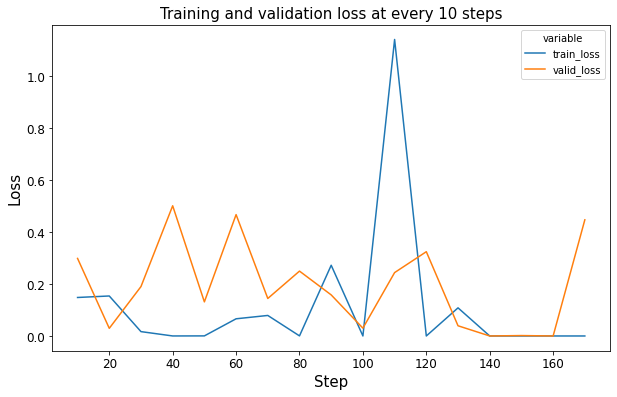

In [52]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='step',
             y='value',
             hue='variable',
             data=ft_results_df2[~ft_results_df2['value'].isna()])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Training and validation loss at every 10 steps',fontsize=15)
plt.xlabel('Step',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.show()

# Use the fine tuned model for inference on test set

In [50]:
test_df = utils.read_data_from_sheets(credentials_path=credentials_path,
                                          sheets_filename='pubmed_manual_curated',
                                          sheets_sheetname='run_1',
                                          start_cell='A1',
                                          end_cell='A57')

In [51]:
test_ids = openai_finetuning.get_test_set_ids(test_df,
                                              id_column='pmid')

In [53]:
pubmed_df = pd.read_csv(pubmed_path,dtype={'pmid':'str'})
test_df2 = pubmed_df[pubmed_df['pmid'].isin(test_ids)][['pmid','abstract']].copy()

In [56]:
test_df2.head()

,pmid,abstract
2,37147285,Failure to achieve complete elimination of tri...
10,36841821,Pellino-1 (PELI1) is an E3 ubiquitin ligase ac...
16,37264081,Activation of the PI3K-mTOR pathway is central...
20,37141396,Triple-negative breast cancers (TNBC) represen...
28,37091185,[INTRODUCTION]Brain metastasis is the terminal...


In [58]:
ft_completions = openai_api.process_pubmed_data(
                        system_path=system_path,
                        user_path=ft_user_path_2,
                        data_df1=test_df2,
                        openai_key_path=openai_key_path,
                        seed=1,
                        temperature=0.0,
                        model='ft:gpt-3.5-turbo-0125:personal:pubmed-ft1:9DEzhV1U',
                        total_tokens=11800,
                        cost_per_input_token=3e-06,
                        cost_per_output_token=6e-06)

	Base prompt messages loaded.
	Necessary columns present in the input df.
Function setup_client complete.
	Client setup complete.
	Processing abstracts through the API.
Function process_pubmed_data complete in 0:00:59.513211. This run costed $0.07.


**Save the completions dictionary as a json.**

In [61]:
with open(ft_completions_path, "w") as ft_file:
    json.dump(ft_completions, ft_file)

**Extract information from the completions endpoint json into a df.**

In [78]:
ft_ner_df = openai_finetuning.get_df_from_completions(ft_completions)

In [81]:
ft_ner_df['pmid'].nunique()

30

**Save the results as a CSV.**

In [83]:
ft_ner_df.to_csv(ft_ner_path,index=False)

**Write the data to Google Sheets.**

In [84]:
ft_ner_df2 = ft_ner_df.copy()
for col in ft_ner_df2.columns:
    
    ft_ner_df2[col] = ft_ner_df2[col].astype('str')

In [86]:
credentials_path = '/Users/mukti/myproject_creds/diesel-monitor-411520-d2d47bd08d20.json'

In [87]:
ft_columns_to_write = ['pmid','drug_name','direct_target','drug-direct_target_interaction','clinical_trials_id']

utils.write_data_to_sheets(df=ft_ner_df2,
                           credentials_path=credentials_path,
                           sheets_filename='pubmed_manual_curated',
                           sheets_sheetname='finetuned_gpt3.5_run_3',
                           columns_to_write=ft_columns_to_write)

In [89]:
test_df2[test_df2['pmid']=='36948246']['abstract'].values

array(['[INTRODUCTION]D-1553 (garsorasib) is a potent and selective oral KRAS[METHODS]Patients with KRAS G12C-mutated NSCLC have administrated D-1553 600 mg orally once daily, 800 mg once daily, 1200 mg once daily, 400 mg twice a day, or 600 mg twice a day in dose escalation. In dose-expansion, all patients received 600 mg twice a day. The safety, pharmacokinetics, and efficacy of D-1553 were evaluated.[RESULTS]Among a total of 79 treated patients, 75 patients (94.9%) reported treatment-related adverse events with 30 patients experiencing grade 3 or 4 events (38.0%). Most of the adverse events were manageable and the patients tolerated the study treatment well. Among 74 patients assessable for efficacy analysis, 30 patients had a partial response and 38 had stable disease with a confirmed objective response rate (ORR) and disease control rate (DCR) of 40.5% and 91.9%, respectively. The median progression-free survival was 8.2 months, and the median duration of response was 7.1 months. 

# Evaluation

# Test code

In [182]:
df1 = pd.DataFrame({'drug name':['tak228','cpt24','kfj24','kgj34'],
                       'targets':[['a','b','c'],['d','e'],['f'],['h']],
                        'pmid':['7436','7436','3974','9735']})

In [183]:
df1

,drug name,targets,pmid
0,tak228,"[a, b, c]",7436
1,cpt24,"[d, e]",7436
2,kfj24,[f],3974
3,kgj34,[h],9735


In [184]:
df1.to_dict(orient='records')

[{'drug name': 'tak228', 'targets': ['a', 'b', 'c'], 'pmid': '7436'},
 {'drug name': 'cpt24', 'targets': ['d', 'e'], 'pmid': '7436'},
 {'drug name': 'kfj24', 'targets': ['f'], 'pmid': '3974'},
 {'drug name': 'kgj34', 'targets': ['h'], 'pmid': '9735'}]

In [185]:
all_rows = []
test_dict = {}
for data in df1.to_dict(orient='records'):
    
    pmid = data.pop('pmid')
    
    if pmid not in test_dict:
        test_dict[pmid] = [data]
    else:
        test_dict[pmid].append(data)

for key,val in test_dict.items():
    all_rows.append({key:val})
    

In [186]:
test_dict

{'7436': [{'drug name': 'tak228', 'targets': ['a', 'b', 'c']},
  {'drug name': 'cpt24', 'targets': ['d', 'e']}],
 '3974': [{'drug name': 'kfj24', 'targets': ['f']}],
 '9735': [{'drug name': 'kgj34', 'targets': ['h']}]}

In [187]:
all_rows

[{'7436': [{'drug name': 'tak228', 'targets': ['a', 'b', 'c']},
   {'drug name': 'cpt24', 'targets': ['d', 'e']}]},
 {'3974': [{'drug name': 'kfj24', 'targets': ['f']}]},
 {'9735': [{'drug name': 'kgj34', 'targets': ['h']}]}]

In [195]:
all_rows[0].keys()

dict_keys(['7436'])

In [197]:
next(iter(all_rows[0].keys()))

'7436'

In [192]:
for b in all_rows:
    print(b.keys())

dict_keys(['7436'])
dict_keys(['3974'])
dict_keys(['9735'])


In [142]:
a = {'drug name': 'tak228', 'targets': ['a', 'b', 'c'], 'pmid': '7436'}

In [175]:
a.pop('pmid')

'7436'

In [176]:
a

{'drug name': 'tak228', 'targets': ['a', 'b', 'c']}

In [245]:
examples = openai_finetuning.estimate_finetuning_cost(test_path)

In [246]:
for example in examples[0]:
    print(example.get('messages'))

AttributeError: 'str' object has no attribute 'get'